<a href="https://colab.research.google.com/github/veenasridhar/Neural-Network/blob/main/Age_Regressor_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir data
# !gdown https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk # Note: old dataset link - currently broken, might get fixed and work again in future.
!gdown https://archive.org/download/UTKFace/UTKFace.tar.gz
!mv UTKFace.tar.gz data

Downloading...
From: https://archive.org/download/UTKFace/UTKFace.tar.gz
To: /content/UTKFace.tar.gz
100% 107M/107M [00:05<00:00, 19.8MB/s]


In [5]:
import tarfile
import os
import glob
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np

def load_file_names():
    # Check if data has been extracted and if not extract it
    if (os.path.isdir("./data/UTKFace")):
        print("Data set already extracted...")
    else:
        print("Extracting data set...")
        tar = tarfile.open("./data/UTKFace.tar.gz")
        tar.extractall("./data")
        tar.close()

    # Get a list of all files in data set
    files = glob.glob("./data/UTKFace/*.jpg")
    labels = [int(f_name.split("/")[-1].split("_")[0]) for f_name in files]
    return files, labels

Extracting data set...


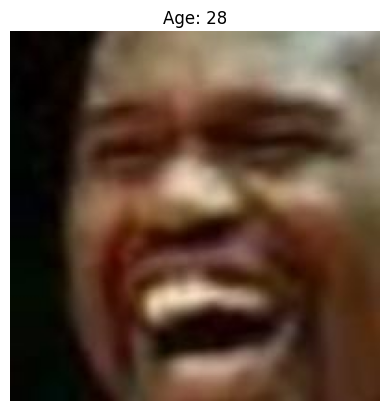

<class 'list'>
<class 'list'>


In [6]:
files, labels = load_file_names()
# For Windows Machine
#files = glob.glob("./data/UTKFace/*.jpg")
#labels = [int(os.path.basename(f_name).split("_")[0]) for f_name in files]
img = plt.imread(files[0])
plt.imshow(img)
plt.title("Age: {}".format(labels[0]))
plt.axis("off")
plt.show()
print(type(files))
print(type(labels))

In [7]:
print(np.unique(labels))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]


In [19]:
class MyModel(k.Model):
    def __init__(self):
        # Create layers
        super(MyModel, self).__init__()
        self.conv0 = k.layers.Conv2D(filters= 8,kernel_size=(5,5), activation='relu',strides=4)
        self.conv1 = k.layers.Conv2D(filters = 16, kernel_size=(5,5), activation='relu', strides=4)
        self.flatten = k.layers.Flatten()
        self.dropout = k.layers.Dropout(rate=0.2)
        self.dense0 = k.layers.Dense(128,activation='relu')
        self.dense1 = k.layers.Dense(64,activation='relu')
        self.dense2 = k.layers.Dense(1, activation='relu')

    def call(self, inputs, training=False):
        # Implement forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dropout(output,training = training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

In [26]:
N_epochs = 50
learning_rate = 0.01
batch_size = 64
N_training_examples = 20000
N_validation_examples = 4*batch_size
N_parallel_iterations = 4
N_prefetch = 8
N_shuffle_buffer = 20000

In [31]:
def parse_func(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string)
    image = tf.cast(image_decoded,tf.float32)/255.0
    label = tf.expand_dims(tf.cast(label, tf.float32), axis=-1)
    return image, label

""" We now build a tensorflow Dataset object that shuffles the data with a shuffle buffer of size "N_shuffle_buffer",
applies the parse_func via the .map() function with "N_parallel_iterations", creates batches
of size "batch_size" and prefetches with "N_prefetch". Please fill in the missing code. """

def build_dataset(files, labels, batch_size):
    # Create tf data set of files and labels
    ds = tf.data.Dataset.from_tensor_slices((files,labels))
    ds = ds.shuffle(N_shuffle_buffer)
    ds = ds.map(parse_func,N_parallel_iterations)
    # Batch and prefetch
    ds = ds.batch(batch_size).repeat().prefetch(N_prefetch)
    return ds

# Shuffle data and labels
shuffle_idx = np.arange(len(files))
np.random.shuffle(shuffle_idx)
files = [files[i] for i in shuffle_idx]
labels = [labels[i] for i in shuffle_idx]
train_ds = build_dataset(files[0:N_training_examples],
                                     labels[0:N_training_examples], batch_size)
validation_ds = build_dataset(files[N_training_examples:N_training_examples+N_validation_examples],
                                          labels[N_training_examples:N_training_examples+N_validation_examples],
                                          batch_size)
test_ds = build_dataset(files[N_training_examples+N_validation_examples:],
                                    labels[N_training_examples+N_validation_examples:], batch_size)

In [32]:
def loss(y, y_pred):
    return tf.reduce_mean(tf.abs(y - y_pred))

# Define training step as a complete graph
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # Predict with model on "x"
        y_pred = model.call(x,True)
        loss_val = loss(y,y_pred)
    grads = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

In [33]:
mdl = MyModel()
opt = tf.optimizers.RMSprop(learning_rate)
mdl.build((batch_size, 200, 200, 3))
mdl.summary()

Model: "my_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  608       
                                                                 
 conv2d_7 (Conv2D)           multiple                  3216      
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  295040    
                                                                 
 dense_10 (Dense)            multiple                  8256      
                                                                 
 dense_11 (Dense)            multiple                  6

In [34]:
# Run training
epoch = 0
train_loss = 0.0
train_iters = 0
for train_images, train_labels in train_ds:
    train_loss += train_step(mdl,opt,train_images,train_labels)
    train_iters += 1
    # An epoch is completed
    if train_iters == int(N_training_examples/batch_size):
        epoch += 1
        val_loss = 0.0
        val_iters = 0
        for val_images, val_labels in validation_ds:
            # Predict on validation images
            y_pred = mdl(val_images)
            # Compute loss for validation
            loss_val = loss(val_labels,y_pred)
            val_loss += loss_val
            val_iters += 1
            if val_iters == int(N_validation_examples/batch_size):
                print("Epoch: {} Training loss: {:.5} Validation loss {:.5}"
                      .format(epoch, train_loss/train_iters, val_loss/val_iters))
                break
        train_loss = 0.0
        train_iters = 0
    if epoch == N_epochs:
        break

Epoch: 1 Training loss: 19.135 Validation loss 16.661
Epoch: 2 Training loss: 17.661 Validation loss 16.86
Epoch: 3 Training loss: 14.613 Validation loss 12.483
Epoch: 4 Training loss: 12.126 Validation loss 10.959
Epoch: 5 Training loss: 10.669 Validation loss 12.12
Epoch: 6 Training loss: 10.122 Validation loss 8.9336
Epoch: 7 Training loss: 9.7694 Validation loss 9.0062
Epoch: 8 Training loss: 9.3421 Validation loss 11.83
Epoch: 9 Training loss: 9.2245 Validation loss 9.1626
Epoch: 10 Training loss: 8.9964 Validation loss 9.925
Epoch: 11 Training loss: 8.8884 Validation loss 8.7364
Epoch: 12 Training loss: 8.73 Validation loss 8.5627
Epoch: 13 Training loss: 8.4956 Validation loss 8.7612
Epoch: 14 Training loss: 8.4277 Validation loss 9.4996
Epoch: 15 Training loss: 8.3141 Validation loss 9.3531
Epoch: 16 Training loss: 8.1903 Validation loss 8.3434
Epoch: 17 Training loss: 8.1382 Validation loss 8.0549
Epoch: 18 Training loss: 8.0774 Validation loss 7.8442
Epoch: 19 Training loss: 

In [35]:
# Test model
Num_test_batches = int((len(files)-N_validation_examples-N_validation_examples)/batch_size)
test_loss = 0.0
test_iters = 0
for test_images, test_labels in test_ds:
    # Predict on test images
    y_pred = mdl(test_images)
    # Compute test loss
    test_loss += loss(test_labels,y_pred)
    test_iters += 1
    if test_iters == Num_test_batches:
        print("Test loss: {:.5}".format(test_loss/test_iters))
        break

Test loss: 7.7722


In [36]:
from google.colab import files
uploaded = files.upload()
fn = list(uploaded.keys())[0]

Saving nihal-karkala-EgtLW0teNyg-unsplash.jpg to nihal-karkala-EgtLW0teNyg-unsplash.jpg


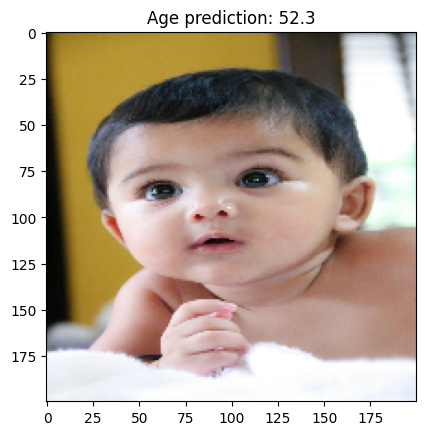

In [37]:
""" For predicting on the uploaded image, open and decode it using tf.io. After that we also need to normalize and resize it using tf.image.resize. Hint: For predicting with our model we need to add a batch dimension
of 1, since we effectively feed our model with a batch containing only one image."""


# Load and predict on an image
# Load image with path "fn"
image_string = tf.io.read_file(fn)
# Decode the image and add a batch dimension
image_decoded = tf.expand_dims(tf.io.decode_jpeg(image_string,channels =3),axis = 0)
# Normalize, resize to 200x200 pixels and cast image to tf.float32
image = tf.image.resize(tf.cast(image_decoded,tf.float32)/255.0,(200,200))
age = mdl(image)

# Plot image and prediction
plt.imshow(np.squeeze(image.numpy()))
plt.title("Age prediction: {:.3}".format(np.squeeze(age.numpy())))
plt.show()